## Import of required libraries

In [ ]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf


from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.models import Sequential
# layers to built deep learning model
from tensorflow.keras.layers import TextVectorization, Input, LSTM, Dropout, Bidirectional, Dense, Embedding
#metrics
from tensorflow.keras.metrics import Precision, Recall, Accuracy, BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping



In [ ]:
df = pd.read_csv('youtoxic_english_1000.csv')
df.head()

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,False,False,False,False
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,False,False,False,False
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,True,True,False,False,True,False,False,False,False,False,False,False
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,False,False,False,False
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
bool_col = df.select_dtypes(include = ['bool'])
# Convert boolean columns to integers
df[bool_col.columns] = df[bool_col.columns].astype(int)
df.head()

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,0,0,0,0,0,0,0,0,0,0,0,0
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,1,1,0,0,0,0,0,0,0,0,0,0
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,1,1,0,0,1,0,0,0,0,0,0,0
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,0,0,0,0,0,0,0,0,0,0,0,0
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.columns.get_loc

<bound method Index.get_loc of Index(['CommentId', 'VideoId', 'Text', 'IsToxic', 'IsAbusive', 'IsThreat',
       'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist',
       'IsNationalist', 'IsSexist', 'IsHomophobic', 'IsReligiousHate',
       'IsRadicalism'],
      dtype='object')>

In [ ]:
df_sum=df.copy()

## Preprocess

In [ ]:
df_sum['Hate'] = df.select_dtypes( include= ['int']).any(axis=1).astype(int)
df_sum.drop(df_sum.columns[[0,1,3,4,5,6,7,8,9,10,11,12,13,14]], axis=1, inplace=True)
df_sum.head()

,Text,Hate
0,If only people would just take a step back and...,0
1,Law enforcement is not trained to shoot to app...,1
2,\nDont you reckon them 'black lives matter' ba...,1
3,There are a very large number of people who do...,0
4,"The Arab dude is absolutely right, he should h...",0


In [ ]:
X = df_sum['Text']
y = df_sum['Hate'].values

In [ ]:
# set up dictionary size q-ty of words
MAX_FEATURES=100000 # Maximum vocab size.

In [ ]:
# create vetorizer-layer
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

2023-11-23 21:25:19.610223: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-11-23 21:25:19.610257: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-23 21:25:19.610275: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-d8103776-8bc3-42d5-af3b-9ad38442056c): /proc/driver/nvidia/version does not exist
2023-11-23 21:25:19.610563: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
#Now that the vocab layer has been created, call `adapt` on the
# text-only dataset to create the vocabulary. You don't have to batch,
# but for large datasets this means we're not keeping spare copies of
# the dataset.

vectorizer.adapt(X.values) #teach the vectorizer all the words in the text(train the vectorizer)
print(X)

0      If only people would just take a step back and...
1      Law enforcement is not trained to shoot to app...
2      \nDont you reckon them 'black lives matter' ba...
3      There are a very large number of people who do...
4      The Arab dude is absolutely right, he should h...
                             ...                        
995    I remember that they sent in the national defe...
996    Stats don`t represent the problem. Race baitin...
997    The quote from the mother... Wow that hit hard...
998                              this video is so racist
999        God, the narrator has such an annoying lisp. 
Name: Text, Length: 1000, dtype: object


## Create dataset in Tensorflow format with tf.data.Dataset API 

In [ ]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
#creating dataset
dataset = tf.data.Dataset.from_tensor_slices((X, y)) #X, y are assumed to be NumPy arrays or tensors. Each element of the dataset will be a tuple
dataset = dataset.cache() #adds caching to the dataset. Caching keeps the elements of the dataset in memory
dataset = dataset.shuffle(1000) #Shuffling is important during training to ensure that the model sees a different order of examples in each epoch.
dataset = dataset.batch(8) # number of lines(samples) in the set 8 
dataset = dataset.prefetch(8) # helps bottlenecks

In [ ]:
# Integer or None. Number of samples grouped in the set. If unspecified, batch_size will default to 32. 
batch_X, batch_y=dataset.as_numpy_iterator().next()
batch_X, batch_y

(array([b"It's sad that I have to watch a YouTube video to get a non biased report about what's going on in Ferguson! Thank You!",
        b'ana kasparian is the most beautiful woman in the world',
        b'Glad these protestors affect so many people, gives the public more reasons to hate them',
        b'THE UGLY TRUTH:\n\nIf you talk like a THUG, act like a THUG, walk like a THUG, and live like a THUG... Then you will die like a THUG!\n\n"Live by the sword die by the sword." - "Don\'t hate the player, hate the game!"\n\nThis was not an innocent little child just walking down the street who got shot in the back. If we cannot blame the parents then we must look at the individual who in this case was an adult.\xc2\xa0\n\nWhat kind of music did he listen to?\nWhat kind of videos did he view?\nWho were his role models?\nHow did his environment affect him?\nWho were the enablers?\nWho did he associate with?\nBut most importantly, when will he be accountable for his own actions? Unfortunat

In [ ]:
len(dataset)

125

In [ ]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))
print(len(train))
len(test)

87


12

## Build Deep learning model - Create Sequential Model

In [ ]:
#to sep up sequence of the NN model

model = Sequential()

# Start by creating an explicit input layer. It needs to have a shape of
# (1,) (because we need to guarantee that there is exactly one string
# input per batch), and the dtype needs to be 'string'

model.add(Input(shape=(1,), dtype=tf.string))

# The first layer in our model is the vectorization layer. After this
# layer, we have a tensor of shape (batch_size, max_len) containing
# vocab indices

model.add(vectorizer)

# Create the embedding layer 

model.add(Embedding(MAX_FEATURES+1, 16))# +1 for uknown words,

# The model will take as input an integer matrix of size (batch,
# input_length), and the largest integer (i.e. word index) in the input
# should be no larger than MAX_FEATURES+1(vocabulary size).
# Now model.output_shape is (None, None, 16), where `None` is the batch
# dimension, input_lenth - None, output dimantion (16)
# Bidirectional LSTM Layer

model.add(Bidirectional(LSTM(16, activation='tanh'))) #Long Short-Term Memory layer Default: hyperbolic tangent (tanh)

# Feature extractor Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

# Final output layer 
model.add(Dense(1, activation='sigmoid')) 

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy']) 
# binary_crossentropy for binary classification 
# Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1800)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1800, 16)          1600016   
                                                                 
 bidirectional (Bidirectiona  (None, 32)               4224      
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 64)               

In [ ]:
#Stop training when a monitored metric has stopped improving
#Implement early stopping to monitor the validation loss and stop training when it starts to degrade. 
#This prevents the model from overfitting.
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
#patience: Number of epochs with no improvement after which training will be stopped.

In [ ]:
history = model.fit(train, epochs=5, validation_data=val,callbacks=[early_stopping])

Epoch 1/5
87/87 [==============================] - 172s 2s/step - loss: 0.6926 - accuracy: 0.5230 - val_loss: 0.6886 - val_accuracy: 0.5600
Epoch 2/5
87/87 [==============================] - 166s 2s/step - loss: 0.6652 - accuracy: 0.5848 - val_loss: 0.4909 - val_accuracy: 0.7800
Epoch 3/5
87/87 [==============================] - 180s 2s/step - loss: 0.4103 - accuracy: 0.8089 - val_loss: 0.2902 - val_accuracy: 0.9000
Epoch 4/5
87/87 [==============================] - 180s 2s/step - loss: 0.2715 - accuracy: 0.8937 - val_loss: 0.1518 - val_accuracy: 0.9500
Epoch 5/5
87/87 [==============================] - 177s 2s/step - loss: 0.1673 - accuracy: 0.9339 - val_loss: 0.0694 - val_accuracy: 0.9800


## Learning curve

<Figure size 800x500 with 0 Axes>

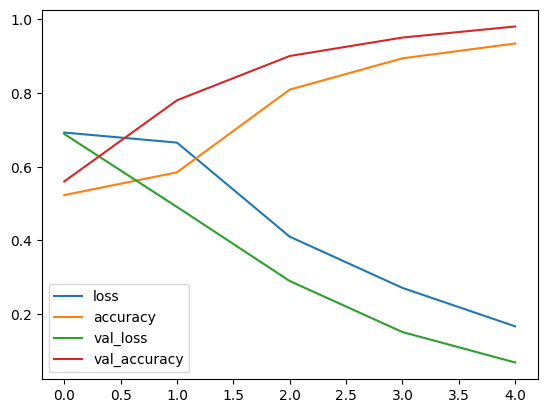

In [ ]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

## Prediction

In [ ]:
input_text = 'You are sucks! I am going to kill you.'

In [ ]:
model.predict(np.array([input_text]))

1/1 [==============================] - 1s 649ms/step


array([[0.70667243]], dtype=float32)

In [ ]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 42ms/step


In [ ]:
(res > 0.5).astype(int)

array([[1]])

In [ ]:
res.shape

(1, 1)

In [ ]:
#checking the batch
batch_X, batch_y = test.as_numpy_iterator().next()


In [ ]:
model.predict(batch_X)

1/1 [==============================] - 0s 111ms/step


array([[0.8805549 ],
       [0.99848354],
       [0.99043113],
       [0.9979947 ],
       [0.07128337],
       [0.2029492 ],
       [0.05250306],
       [0.0125504 ]], dtype=float32)

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 86ms/step


array([[1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0]])

In [ ]:
batch_y

array([1, 1, 1, 1, 0, 0, 0, 0])

## Evaluation of the test data

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    y_pred = model.predict(X_true)
   
    
    # Flatten the predictions - creating one big array
    y_true = y_true.flatten() 
    y_pred = y_pred.flatten()
    
    pre.update_state(y_true, y_pred)
    re.update_state(y_true, y_pred)
    acc.update_state(y_true, y_pred)

1/1 [==============================] - 0s 268ms/step


In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result()}')

Precision: 1.0, Recall:0.9569892287254333, Accuracy:0.9791666865348816


## Model learned well how to predict hate speech and in 100% cases prediction of hate was correct and 95,7% model was able to detect hate patterns, 

In [ ]:
y_true

array([1, 0, 0, 1, 0, 0, 0, 0])

In [ ]:
y_pred

array([0.87143666, 0.09294023, 0.00543903, 0.92579985, 0.12195829,
       0.09052917, 0.04191457, 0.03116497], dtype=float32)

In [ ]:
# Convert probabilities to predicted labels (0 or 1)
y_pred = np.round(y_pred).astype(int)

# Calculate accuracy
accuracy = np.sum(y_true == y_pred) / len(y_true)

print(f'Accuracy: {accuracy:.4f}')

Accuracy: 1.0000


In [ ]:
# Overfitting

overfitting = (0.98 - 1)*100

print(f'Overfitting: {overfitting:.1f}')

Overfitting: -2.0


## Save the model

In [ ]:
# Save the model using SavedModel format

model.save('hate_speech_model', save_format='tf')

INFO:tensorflow:Assets written to: hate_speech_model/assets
INFO:tensorflow:Assets written to: hate_speech_model/assets


In [ ]:
#open the model
model = tf.keras.models.load_model('hate_speech_model')

## Test the saved model

In [ ]:
input_str = 'I love you'

In [ ]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 0s 45ms/step


In [ ]:
res

array([[0.1302176]], dtype=float32)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d8103776-8bc3-42d5-af3b-9ad38442056c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>